<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/8_2_visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Section 8.2 — Visualising the Data, Results, Models and Patterns (Colab)

**What this notebook does**
- Mounts Google Drive (skips if already mounted).
- Loads the prepared district–month dataset.
- Trains four classifiers (Decision Tree, Random Forest, XGBoost, MLP).
- Produces Figures 75–82 (hotspot prevalence, ROC/PR curves, threshold sweep, cumulative gain, feature importance, calibration, and error distribution).
- Saves all images to `MyDrive/Infosys 722/figs` and a metrics table to `MyDrive/Infosys 722/tables`.

> Update the `CSV_PATH` in the **Paths** cell if your file name differs.


In [1]:

# =========================
# Imports & configuration
# =========================
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score, confusion_matrix,
                             precision_score, recall_score, f1_score, accuracy_score)
from sklearn.calibration import calibration_curve

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# Colab Drive mount (safe: only mounts if not already mounted)
try:
    from google.colab import drive  # type: ignore
    if not os.path.ismount('/content/drive'):
        drive.mount('/content/drive')
except Exception:
    pass

SEED = 42
np.random.seed(SEED)
plt.rcParams['figure.dpi'] = 140


Mounted at /content/drive


In [2]:

# =========================
# Paths
# =========================
ROOT = "/content/drive/MyDrive/Infosys 722"
TAB_DIR = os.path.join(ROOT, "tables")
FIG_DIR = os.path.join(ROOT, "figs")
os.makedirs(TAB_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# >>>> UPDATE THIS IF YOUR FILENAME DIFFERS <<<<
CSV_PATH = os.path.join(TAB_DIR, "CrimeData2017_reduced_projected.csv")

print("[Info] Using CSV:", CSV_PATH)
print("[Info] Figures will be saved to:", FIG_DIR)

if not os.path.exists(CSV_PATH):
    print("\n[Error] CSV not found. Listing contents of:", TAB_DIR)
    for fn in sorted(os.listdir(TAB_DIR)):
        print(" -", fn)
    raise FileNotFoundError("Please confirm the file name & path in Google Drive")


[Info] Using CSV: /content/drive/MyDrive/Infosys 722/tables/CrimeData2017_reduced_projected.csv
[Info] Figures will be saved to: /content/drive/MyDrive/Infosys 722/figs


In [3]:

# =========================
# Load data & tidy
# =========================
df = pd.read_csv(CSV_PATH)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns))

if "District" not in df.columns: raise ValueError("Column 'District' is required.")
if "Month" not in df.columns: raise ValueError("Column 'Month' is required.")
if "Total" not in df.columns: raise ValueError("Column 'Total' is required.")

if "Year" not in df.columns:
    df["Year"] = 2017  # project scope

df["_ym"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1)).dt.strftime("%Y-%m")

# Next-month target
if "y_count_next" in df.columns:
    df["y_next"] = df["y_count_next"].astype(float)
else:
    df = df.sort_values(["District","Year","Month"])
    df["y_next"] = df.groupby("District")["Total"].shift(-1).astype(float)

df = df.dropna(subset=["y_next"]).copy()
print("After dropna(y_next) shape:", df.shape)


Loaded shape: (267, 15)
Columns: ['District', 'Month', 'Total', 'District_Month_ArrestRate', 'District_Month_DomesticRate', 'NightShare_DistMonth', 'OutdoorShare_DistMonth', 'Roll3Mean_DistMonth', 'y_count_next', 'District_Month_ArrestRate_logit', 'District_Month_DomesticRate_logit', 'NightShare_DistMonth_logit', 'OutdoorShare_DistMonth_logit', 'Roll3Mean_DistMonth_log1p', 'y_count_next_log1p']
After dropna(y_next) shape: (243, 18)


In [4]:

# =========================
# Time-ordered split & hotspot label
# =========================
timeline = (df[["_ym","Month"]].drop_duplicates().sort_values("Month"))
unique_ym = list(timeline["_ym"])
train_months = unique_ym[:-3]  # Jan-Aug
test_months  = unique_ym[-3:]  # Sep-Nov
df["Split"] = np.where(df["_ym"].isin(test_months), "Test", "Train")
print("Train months:", train_months)
print("Test months :", test_months)

K = 0.10  # top-10% hotspots per month
def label_hotspots(frame, kfrac=K):
    n = frame["District"].nunique()
    k = max(int(math.ceil(kfrac*n)), 1)
    order = frame.sort_values("y_next", ascending=False)
    top_ids = set(order["District"].head(k))
    return frame["District"].isin(top_ids).astype(int)

df["y_bin"] = df.groupby("_ym", group_keys=False).apply(label_hotspots)

# Feature set (safe subset)
cand = [
    "Roll3Mean_DistMonth_log1p",
    "y_count_next_log1p",
    "Total_log1p",
    "y_count_next_log1p.1",
    "District_Month_DomesticRate_logit",
    "District_Month_ArrestRate_logit",
    "NightShare_DistMonth_logit",
    "OutdoorShare_DistMonth_logit",
    "District"
]
features = [c for c in cand if c in df.columns]
if not features:
    features = [c for c in df.columns if c not in ["y_bin","y_next","Split","_ym","Year","Month","Total"]][:12]

train = df[df["Split"]=="Train"].copy()
test  = df[df["Split"]=="Test"].copy()
X_train, y_train = train[features], train["y_bin"].astype(int)
X_test,  y_test  = test[features],  test["y_bin"].astype(int)
print("Shapes — X_train:", X_train.shape, " X_test:", X_test.shape)
print("Features used:", features)


Train months: ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08']
Test months : ['2017-09', '2017-10', '2017-11']
Shapes — X_train: (177, 7)  X_test: (66, 7)
Features used: ['Roll3Mean_DistMonth_log1p', 'y_count_next_log1p', 'District_Month_DomesticRate_logit', 'District_Month_ArrestRate_logit', 'NightShare_DistMonth_logit', 'OutdoorShare_DistMonth_logit', 'District']


/tmp/ipython-input-609583071.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["y_bin"] = df.groupby("_ym", group_keys=False).apply(label_hotspots)


In [5]:

# =========================
# Train models & collect metrics
# =========================
models = {}
models["Decision Tree"] = DecisionTreeClassifier(criterion="gini", max_depth=6, min_samples_split=10, random_state=SEED)
models["Random Forest"] = RandomForestClassifier(n_estimators=300, max_features="sqrt", max_depth=None, random_state=SEED, n_jobs=-1)
if HAS_XGB:
    models["XGBoost"] = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=6,
                                      subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
                                      random_state=SEED, n_jobs=-1)
models["Neural Network (MLP)"] = MLPClassifier(hidden_layer_sizes=(100,), activation="relu",
                                               solver="adam", learning_rate_init=0.001, max_iter=300, random_state=SEED)

for name, mdl in models.items():
    mdl.fit(X_train, y_train)

rows, all_scores = [], {}
for name, mdl in models.items():
    if hasattr(mdl, "predict_proba"):
        p_test = mdl.predict_proba(X_test)[:,1]
    elif hasattr(mdl, "decision_function"):
        from sklearn.preprocessing import minmax_scale
        p_test = minmax_scale(mdl.decision_function(X_test))
    else:
        p_test = mdl.predict(X_test)

    y_pred = (p_test >= 0.5).astype(int)
    rows.append([
        name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, zero_division=0),
        recall_score(y_test, y_pred, zero_division=0),
        f1_score(y_test, y_pred, zero_division=0),
        roc_auc_score(y_test, p_test),
        len(X_train), len(X_test), 2017
    ])
    all_scores[name] = (p_test, y_pred)

res = pd.DataFrame(rows, columns=["Model","Accuracy","Precision","Recall","F1","ROC_AUC","TrainRows","TestRows","EvalYear"]).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
res


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,TrainRows,TestRows,EvalYear
0,XGBoost,0.924242,0.642857,1.000000,0.782609,0.961014,177,66,2017
1,Random Forest,0.863636,0.500000,0.555556,0.526316,0.953216,177,66,2017
2,Decision Tree,0.833333,0.400000,0.444444,0.421053,0.709552,177,66,2017
3,Neural Network (MLP),0.848485,0.000000,0.000000,0.000000,0.692008,177,66,2017


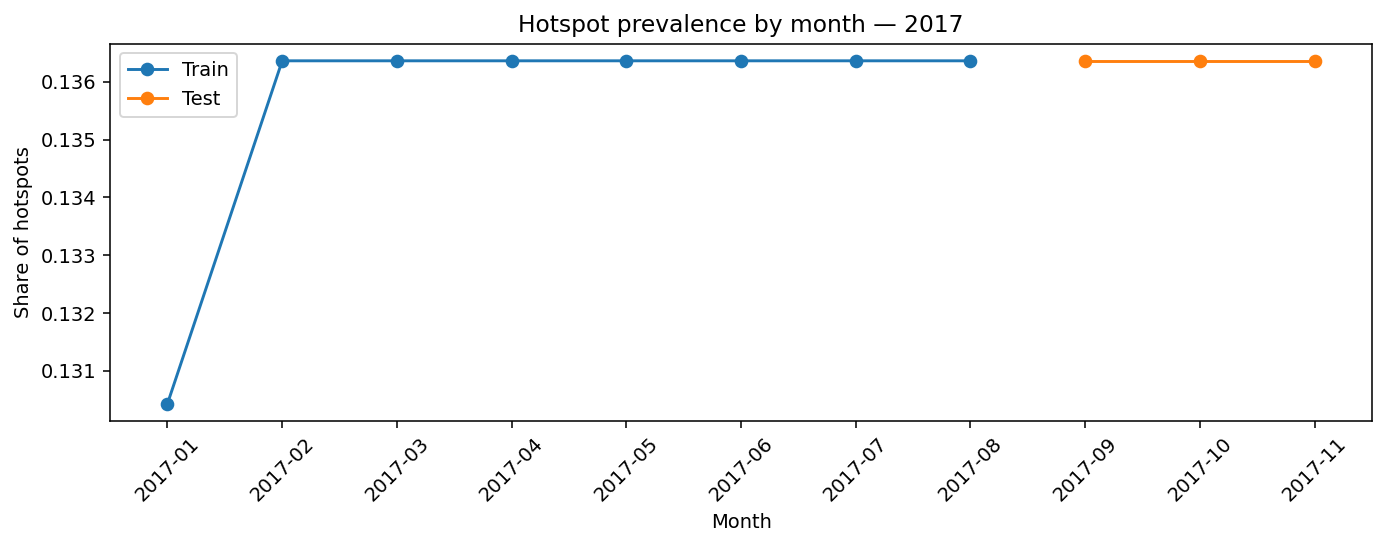

In [6]:

# Figure 75 — Hotspot prevalence by month
by_m = (df.groupby(["_ym","Split"])["y_bin"].mean().unstack("Split")
          .reindex(sorted(df["_ym"].unique(), key=lambda s: int(s.split("-")[1]))))
plt.figure(figsize=(10,4))
plt.plot(by_m.index, by_m.get("Train",0).values, marker="o", label="Train")
plt.plot(by_m.index, by_m.get("Test",0).values, marker="o", label="Test")
plt.title("Hotspot prevalence by month — 2017")
plt.ylabel("Share of hotspots"); plt.xlabel("Month"); plt.legend(); plt.xticks(rotation=45); plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig75_hotspot_prevalence.png"), dpi=160, bbox_inches="tight")
plt.show()


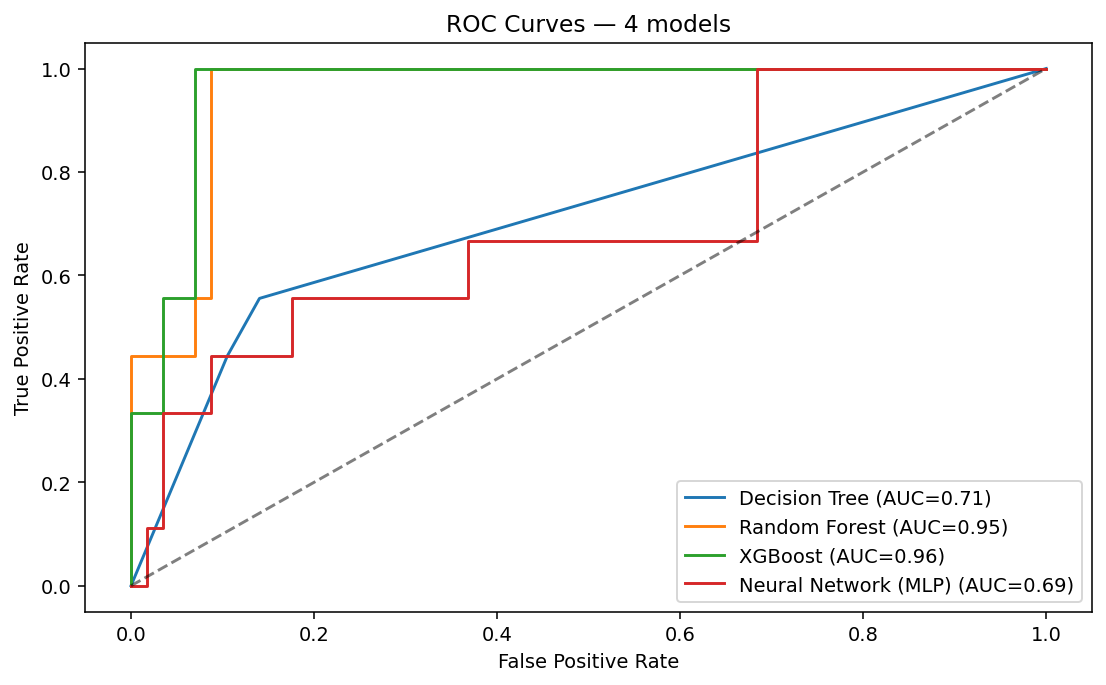

In [7]:

# Figure 76 — ROC curves (4 models)
plt.figure(figsize=(8,5))
for name, (p, _) in all_scores.items():
    fpr, tpr, _ = roc_curve(y_test, p)
    auc = roc_auc_score(y_test, p)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.title("ROC Curves — 4 models"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig76_roc_4models.png"), dpi=160, bbox_inches="tight")
plt.show()


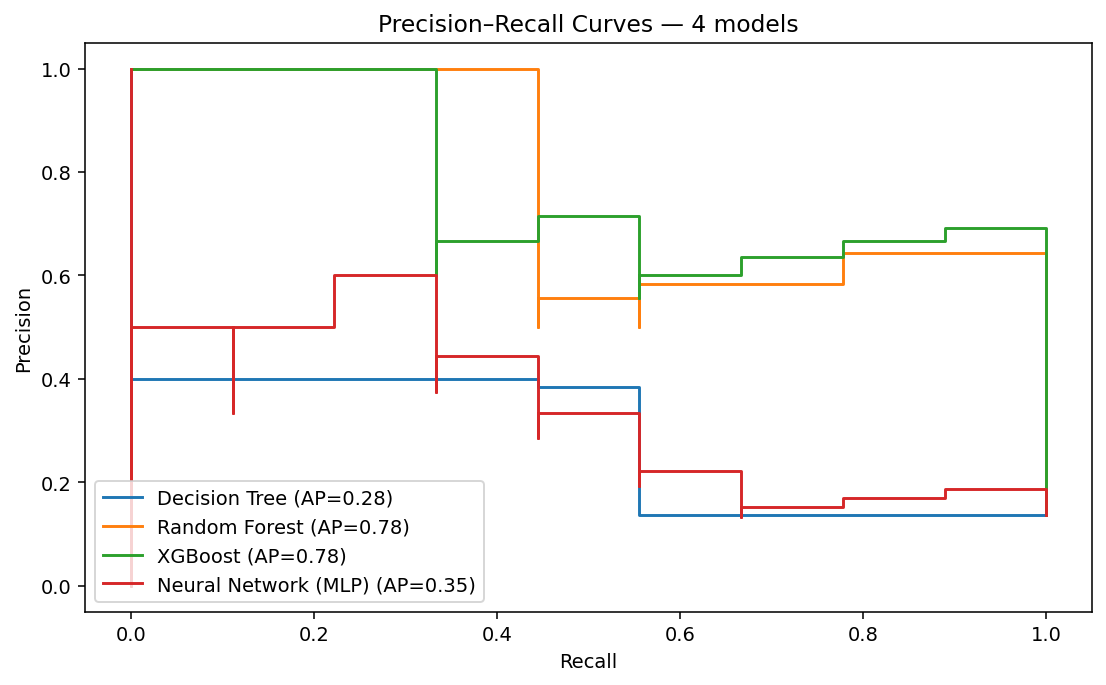

In [8]:

# Figure 77 — Precision–Recall curves (4 models)
plt.figure(figsize=(8,5))
for name, (p, _) in all_scores.items():
    precision, recall, _ = precision_recall_curve(y_test, p)
    ap = average_precision_score(y_test, p)
    plt.step(recall, precision, where='post', label=f"{name} (AP={ap:.2f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curves — 4 models"); plt.legend(loc="lower left"); plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig77_pr_4models.png"), dpi=160, bbox_inches="tight")
plt.show()


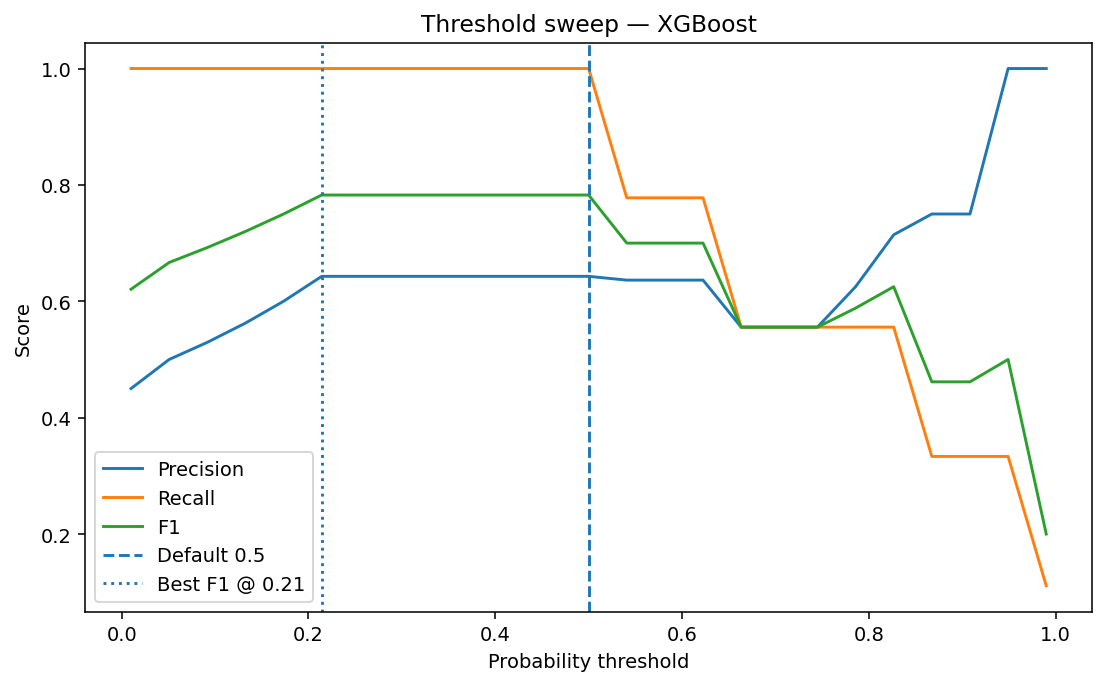

[Info] XGBoost: Best F1=0.783 at threshold=0.21


In [9]:

# Figure 78 — Threshold sweep (XGBoost preferred; else RF)
target_model = "XGBoost" if ("XGBoost" in all_scores) else "Random Forest"
p = all_scores[target_model][0]
ths = np.linspace(0.01, 0.99, 25)
P,R,F = [],[],[]
for t in ths:
    yhat = (p >= t).astype(int)
    P.append(precision_score(y_test, yhat, zero_division=0))
    R.append(recall_score(y_test, yhat, zero_division=0))
    F.append(f1_score(y_test, yhat, zero_division=0))
best_idx = int(np.argmax(F)); best_t = ths[best_idx]; best_f1 = F[best_idx]
plt.figure(figsize=(8,5))
plt.plot(ths, P, label="Precision"); plt.plot(ths, R, label="Recall"); plt.plot(ths, F, label="F1")
plt.axvline(0.5, linestyle="--", color="tab:blue", label="Default 0.5")
plt.axvline(best_t, linestyle=":", color="tab:blue", label=f"Best F1 @ {best_t:.2f}")
plt.title(f"Threshold sweep — {target_model}"); plt.xlabel("Probability threshold"); plt.ylabel("Score"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig78_threshold_sweep.png"), dpi=160, bbox_inches="tight")
plt.show()
print(f"[Info] {target_model}: Best F1={best_f1:.3f} at threshold={best_t:.2f}")


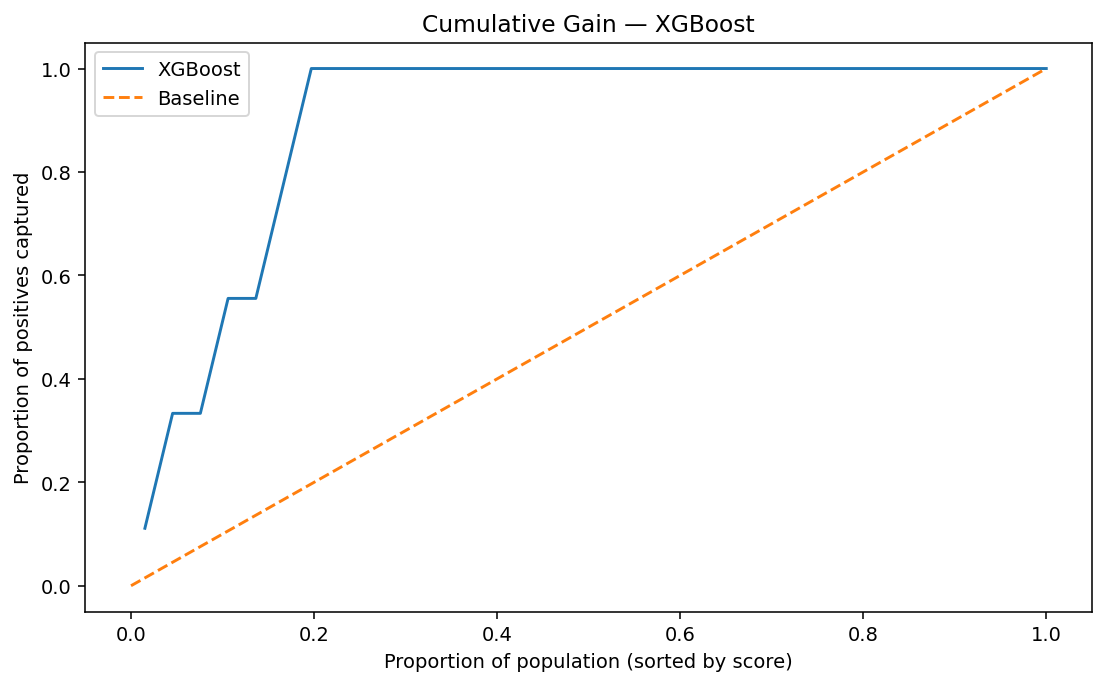

In [10]:

# Figure 79 — Cumulative Gain (target model)
target_model = "XGBoost" if ("XGBoost" in all_scores) else "Random Forest"
p = all_scores[target_model][0]
order = np.argsort(-p); y_sorted = y_test.values[order]
cum_pos = np.cumsum(y_sorted); total_pos = cum_pos[-1] if len(cum_pos)>0 else 1
prop_pop = np.arange(1, len(y_sorted)+1) / len(y_sorted)
gain = cum_pos / total_pos if total_pos>0 else np.zeros_like(cum_pos)
plt.figure(figsize=(8,5))
plt.plot(prop_pop, gain, label=target_model); plt.plot([0,1],[0,1],'--',label="Baseline")
plt.xlabel("Proportion of population (sorted by score)"); plt.ylabel("Proportion of positives captured")
plt.title(f"Cumulative Gain — {target_model}"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig79_cumulative_gain.png"), dpi=160, bbox_inches="tight")
plt.show()


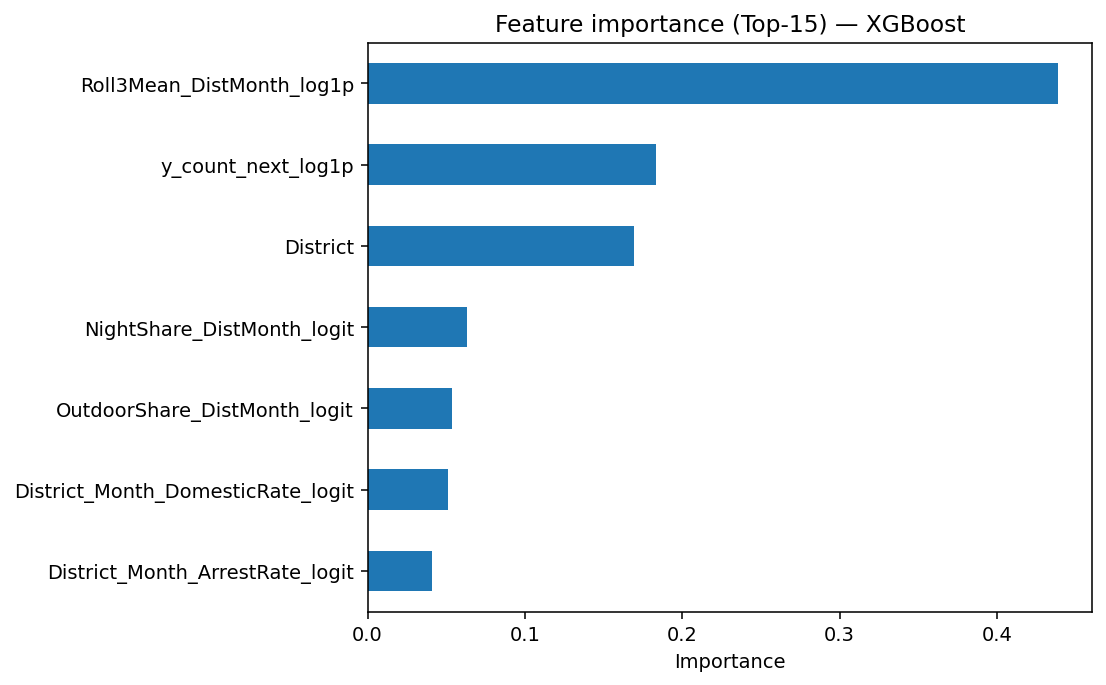

In [16]:
# Figure 80 — Feature importance (XGB preferred; else RF)
# 1) Select model priority
preferred = ["XGBoost", "Random Forest", "Decision Tree"]
if 'models' not in globals():
    raise RuntimeError("Expected a dict `models` with trained models.")

# If all_scores exists, use it; otherwise, fall back to default order
candidates = [m for m in preferred if m in models]
if len(candidates) == 0:
    raise RuntimeError("No suitable model found in `models`.")
mdl_name = candidates[0]

mdl = models[mdl_name]

# 2) Handle Pipeline: get the actual estimator inside
base_est = mdl
if hasattr(mdl, "named_steps"):  # sklearn Pipeline case
    # Find the first step that has feature_importances_ or coef_
    for step in mdl.named_steps.values():
        if hasattr(step, "feature_importances_") or hasattr(step, "coef_"):
            base_est = step
            break

# 3) Get feature names (prefer X_train columns if available)
if 'X_train' in globals():
    feat_names = list(getattr(X_train, 'columns', range(len(getattr(base_est, 'feature_importances_', [])))))
else:
    # fallback to predefined features list
    feat_names = features if 'features' in globals() else None

# 4) Get importance values
# For tree models use feature_importances_, for linear models use abs(coef_)
if hasattr(base_est, "feature_importances_"):
    importances = base_est.feature_importances_
elif hasattr(base_est, "coef_"):
    importances = np.abs(np.ravel(base_est.coef_))
else:
    raise AttributeError(f"{mdl_name} has no attribute `feature_importances_` or `coef_`.")

# If feature names are still missing, create generic ones
if feat_names is None:
    feat_names = [f"f{i}" for i in range(len(importances))]

# Align lengths (in case features and importances do not match perfectly)
n = min(len(importances), len(feat_names))
imp_series = pd.Series(importances[:n], index=feat_names[:n]).sort_values(ascending=False).head(15)

# 5) Plot top-15 features
plt.figure(figsize=(8, 5))
imp_series.iloc[::-1].plot(kind="barh")
plt.xlabel("Importance")
plt.title(f"Feature importance (Top-15) — {mdl_name}")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig80_feature_importance.png"), dpi=160, bbox_inches="tight")
plt.show()


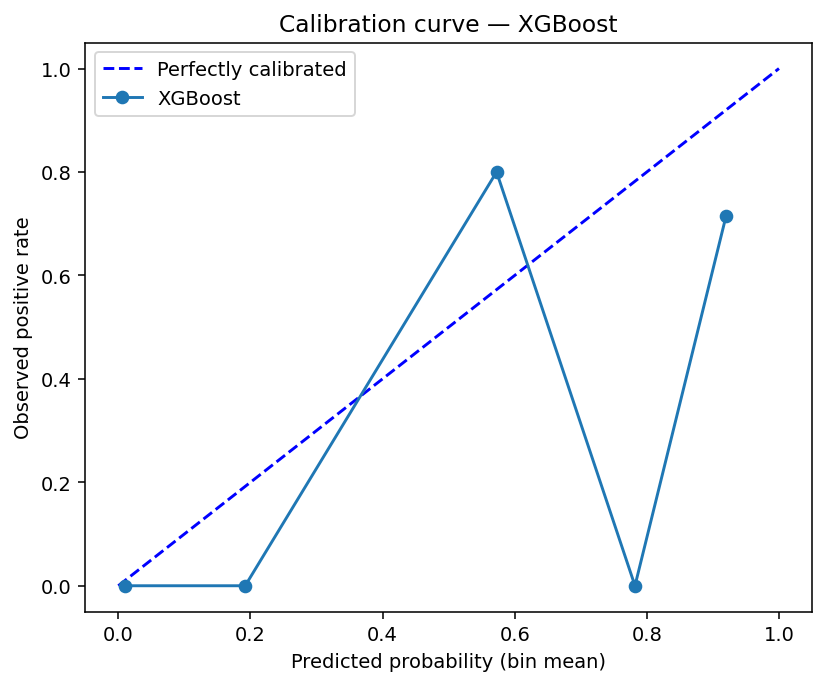

In [13]:

# Figure 81 — Calibration curve (target model)
target_model = "XGBoost" if ("XGBoost" in all_scores) else "Random Forest"
p = all_scores[target_model][0]
prob_true, prob_pred = calibration_curve(y_test, p, n_bins=6, strategy="uniform")
plt.figure(figsize=(6,5))
plt.plot([0,1],[0,1],'b--',label="Perfectly calibrated")
plt.plot(prob_pred, prob_true, 'o-', label=target_model)
plt.xlabel("Predicted probability (bin mean)"); plt.ylabel("Observed positive rate")
plt.title(f"Calibration curve — {target_model}"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig81_calibration_curve.png"), dpi=160, bbox_inches="tight")
plt.show()


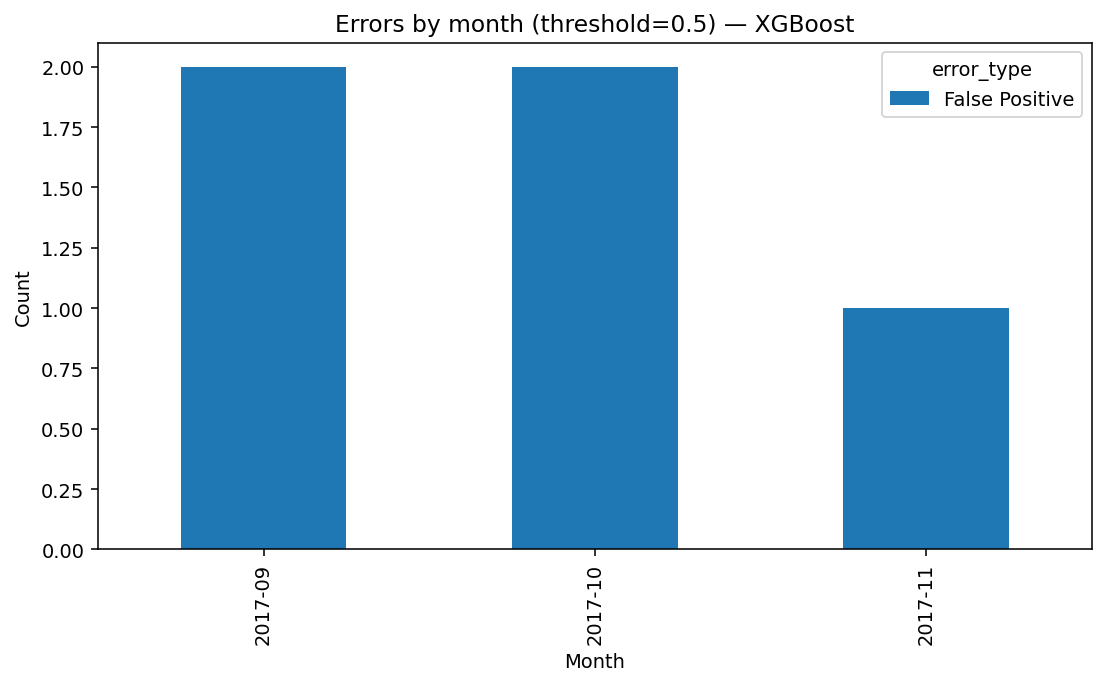

In [14]:

# Figure 82 — Error distribution by month (threshold=0.5)
target_model = "XGBoost" if ("XGBoost" in all_scores) else "Random Forest"
p = all_scores[target_model][0]; y_pred = (p >= 0.5).astype(int)
tmp = test.copy(); tmp["y_pred"] = y_pred
tmp["error_type"] = np.where((tmp["y_bin"]==1) & (tmp["y_pred"]==0), "False Negative",
                    np.where((tmp["y_bin"]==0) & (tmp["y_pred"]==1), "False Positive", "Correct"))
err = (tmp[tmp["error_type"]!="Correct"].groupby("_ym")["error_type"].value_counts()
         .unstack("error_type").fillna(0))
err = err.reindex(sorted(err.index, key=lambda s: int(s.split("-")[1])))
err.plot(kind="bar", stacked=False, figsize=(8,5))
plt.title(f"Errors by month (threshold=0.5) — {target_model}"); plt.xlabel("Month"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "fig82_errors_by_month.png"), dpi=160, bbox_inches="tight")
plt.show()


In [15]:

# Save metrics table
out_csv = os.path.join(TAB_DIR, "table_models_metrics_8_2.csv")
res.to_csv(out_csv, index=False)
print("[Saved]", out_csv)


[Saved] /content/drive/MyDrive/Infosys 722/tables/table_models_metrics_8_2.csv
